In [167]:
from db import DB
import pandas as pd
import pendulum
import numpy as np
from model import fip_model
import matplotlib.pyplot as plt
import seaborn as sns

In [168]:
db = DB()

end = pendulum.datetime(2024,6,30)
start = end.subtract(months=13)

query_string = f'''
    SELECT 
        SYMBOL, 
        TIMESTAMP, 
        CLOSE
    FROM HISTORICAL_DATA 
    WHERE TIMESTAMP BETWEEN '{start}' AND '{end}' 
    ORDER BY SYMBOL, TIMESTAMP;
'''

df = db.execute_df(query_string)

df.to_csv('data.csv',index=False)

/home/andrew/Projects/Quant/quant_workflow/db.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_string, self.conn)


In [169]:
df = pd.read_csv('data.csv', parse_dates=['timestamp'])

df

,symbol,timestamp,close
0,A,2023-05-30,116.67
1,A,2023-05-31,114.62
2,A,2023-06-01,115.21
3,A,2023-06-02,117.15
4,A,2023-06-05,117.28
...,...,...,...
1013913,ZYME,2024-06-24,8.40
1013914,ZYME,2024-06-25,8.36
1013915,ZYME,2024-06-26,8.40
1013916,ZYME,2024-06-27,8.41


In [170]:
df['ret'] = df.groupby('symbol')['close'].pct_change()

df['month'] = df['timestamp'].dt.to_period('M').astype(str)

df['up'] = np.where(df['ret'] > 0, 1, 0)

df['down'] = np.where(df['ret'] < 0, 1, 0)

df['total'] = 1

df = df.groupby(['symbol','month'])[['timestamp','close','up','down', 'total']].agg({'timestamp': 'last','close': 'last','up':'sum','down':'sum', 'total':'sum'})

df.reset_index("month",inplace=True)
df.reset_index("symbol",inplace=True)

df['%neg-%pos'] = (df['down']-df['up']) / df['total']

df


,symbol,month,timestamp,close,up,down,total,%neg-%pos
0,A,2023-05,2023-05-31,114.62,0,1,2,0.500000
1,A,2023-06,2023-06-30,119.39,12,9,21,-0.142857
2,A,2023-07,2023-07-31,120.89,11,9,20,-0.100000
3,A,2023-08,2023-08-31,120.20,12,11,23,-0.043478
4,A,2023-09,2023-09-29,111.02,8,12,20,0.200000
...,...,...,...,...,...,...,...,...
51989,ZYME,2024-02,2024-02-29,12.01,13,7,20,-0.300000
51990,ZYME,2024-03,2024-03-28,10.52,7,11,20,0.200000
51991,ZYME,2024-04,2024-04-30,8.58,7,15,22,0.363636
51992,ZYME,2024-05,2024-05-31,8.48,11,11,22,0.000000


In [171]:
# Calculate PRET
df['ret'] = df.groupby('symbol')['close'].pct_change()

# Log Returns
df['logret'] = np.log(1 + df['ret'])

# Momentum from t-12 to t-2
df['pret'] = df.groupby('symbol')['logret'].rolling(11,11).sum().reset_index(drop=True)
df['pret'] = df.groupby('symbol')['pret'].shift(2)

df.head(15)

,symbol,month,timestamp,close,up,down,total,%neg-%pos,ret,logret,pret
0,A,2023-05,2023-05-31,114.62,0,1,2,0.500000,NaN,NaN,NaN
1,A,2023-06,2023-06-30,119.39,12,9,21,-0.142857,0.041616,0.040773,NaN
2,A,2023-07,2023-07-31,120.89,11,9,20,-0.100000,0.012564,0.012486,NaN
3,A,2023-08,2023-08-31,120.20,12,11,23,-0.043478,-0.005708,-0.005724,NaN
4,A,2023-09,2023-09-29,111.02,8,12,20,0.200000,-0.076373,-0.079447,NaN
5,A,2023-10,2023-10-31,102.83,12,10,22,-0.090909,-0.073770,-0.076633,NaN
6,A,2023-11,2023-11-30,127.14,13,8,21,-0.238095,0.236410,0.212212,NaN
7,A,2023-12,2023-12-29,138.55,12,8,20,-0.200000,0.089744,0.085942,NaN
8,A,2024-01,2024-01-31,129.65,10,11,21,0.047619,-0.064237,-0.066393,NaN
9,A,2024-02,2024-02-29,136.88,11,9,20,-0.100000,0.055766,0.054266,NaN


In [172]:
# Calculate ID

# Rolling average %neg-%pos from t-12 to t-2
df['id'] = df.groupby('symbol')['%neg-%pos'].rolling(11,11).mean().reset_index(drop=True)
df['id'] = df.groupby('symbol')['id'].shift(2)

# Compute ID as sign(pret) * %neg-%pos
df['id'] = np.sign(df['pret']) * df['id']

df.tail()

,symbol,month,timestamp,close,up,down,total,%neg-%pos,ret,logret,pret,id
51989,ZYME,2024-02,2024-02-29,12.01,13,7,20,-0.300000,0.107934,0.102497,NaN,NaN
51990,ZYME,2024-03,2024-03-28,10.52,7,11,20,0.200000,-0.124063,-0.132461,NaN,NaN
51991,ZYME,2024-04,2024-04-30,8.58,7,15,22,0.363636,-0.184411,-0.203844,NaN,NaN
51992,ZYME,2024-05,2024-05-31,8.48,11,11,22,0.000000,-0.011655,-0.011723,NaN,NaN
51993,ZYME,2024-06,2024-06-28,8.51,6,12,19,0.315789,0.003538,0.003531,0.041648,0.01862


In [173]:
# Filter by prc >= 5 and days that features are NaN

df['prclag'] = df.groupby('symbol')['close'].shift(1)

df = df.query("pret == pret and id == id and prclag >= 5").reset_index(drop=True)

df

,symbol,month,timestamp,close,up,down,total,%neg-%pos,ret,logret,pret,id,prclag
0,A,2024-06,2024-06-28,129.39,9,10,19,0.052632,-0.005992,-0.006010,0.176751,-0.052437,130.170
1,AA,2024-06,2024-06-28,39.78,8,11,19,0.157895,-0.101423,-0.106943,0.113123,0.017515,44.270
2,AAL,2024-06,2024-06-28,11.33,7,12,19,0.263158,-0.014783,-0.014893,-0.089845,-0.010138,11.500
3,AAN,2024-06,2024-06-28,9.98,7,10,19,0.157895,0.196356,0.179280,-0.521508,0.025866,8.342
4,AAOI,2024-06,2024-06-28,8.29,7,11,19,0.210526,-0.209724,-0.235372,1.489964,0.010756,10.490
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3416,ZTS,2024-06,2024-06-28,173.36,10,9,19,-0.052632,0.022411,0.022164,-0.013721,0.003535,169.560
3417,ZUMZ,2024-06,2024-06-28,19.48,11,8,19,-0.157895,0.037274,0.036596,0.067955,0.089861,18.780
3418,ZUO,2024-06,2024-06-28,9.93,8,11,19,0.157895,-0.021675,-0.021913,-0.090134,0.002423,10.150
3419,ZWS,2024-06,2024-06-28,29.40,7,12,19,0.263158,-0.061003,-0.062943,0.336729,0.012561,31.310


In [174]:
# Create weighting feature

df['mom_score'] = df['pret'] * abs(df['id'])

df

,symbol,month,timestamp,close,up,down,total,%neg-%pos,ret,logret,pret,id,prclag,mom_score
0,A,2024-06,2024-06-28,129.39,9,10,19,0.052632,-0.005992,-0.006010,0.176751,-0.052437,130.170,0.009268
1,AA,2024-06,2024-06-28,39.78,8,11,19,0.157895,-0.101423,-0.106943,0.113123,0.017515,44.270,0.001981
2,AAL,2024-06,2024-06-28,11.33,7,12,19,0.263158,-0.014783,-0.014893,-0.089845,-0.010138,11.500,-0.000911
3,AAN,2024-06,2024-06-28,9.98,7,10,19,0.157895,0.196356,0.179280,-0.521508,0.025866,8.342,-0.013489
4,AAOI,2024-06,2024-06-28,8.29,7,11,19,0.210526,-0.209724,-0.235372,1.489964,0.010756,10.490,0.016026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3416,ZTS,2024-06,2024-06-28,173.36,10,9,19,-0.052632,0.022411,0.022164,-0.013721,0.003535,169.560,-0.000049
3417,ZUMZ,2024-06,2024-06-28,19.48,11,8,19,-0.157895,0.037274,0.036596,0.067955,0.089861,18.780,0.006107
3418,ZUO,2024-06,2024-06-28,9.93,8,11,19,0.157895,-0.021675,-0.021913,-0.090134,0.002423,10.150,-0.000218
3419,ZWS,2024-06,2024-06-28,29.40,7,12,19,0.263158,-0.061003,-0.062943,0.336729,0.012561,31.310,0.004230


In [175]:
# Bin on momentum first and then ID

df['mombins'] = df.groupby("timestamp")['pret'].transform(lambda x: pd.qcut(x, 2, labels=False))

df['idbins'] = df.groupby(['timestamp','mombins'])['id'].transform(lambda x: pd.qcut(x, 5, labels=False))

df

,symbol,month,timestamp,close,up,down,total,%neg-%pos,ret,logret,pret,id,prclag,mom_score,mombins,idbins
0,A,2024-06,2024-06-28,129.39,9,10,19,0.052632,-0.005992,-0.006010,0.176751,-0.052437,130.170,0.009268,1,3
1,AA,2024-06,2024-06-28,39.78,8,11,19,0.157895,-0.101423,-0.106943,0.113123,0.017515,44.270,0.001981,0,4
2,AAL,2024-06,2024-06-28,11.33,7,12,19,0.263158,-0.014783,-0.014893,-0.089845,-0.010138,11.500,-0.000911,0,3
3,AAN,2024-06,2024-06-28,9.98,7,10,19,0.157895,0.196356,0.179280,-0.521508,0.025866,8.342,-0.013489,0,4
4,AAOI,2024-06,2024-06-28,8.29,7,11,19,0.210526,-0.209724,-0.235372,1.489964,0.010756,10.490,0.016026,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3416,ZTS,2024-06,2024-06-28,173.36,10,9,19,-0.052632,0.022411,0.022164,-0.013721,0.003535,169.560,-0.000049,0,3
3417,ZUMZ,2024-06,2024-06-28,19.48,11,8,19,-0.157895,0.037274,0.036596,0.067955,0.089861,18.780,0.006107,0,4
3418,ZUO,2024-06,2024-06-28,9.93,8,11,19,0.157895,-0.021675,-0.021913,-0.090134,0.002423,10.150,-0.000218,0,3
3419,ZWS,2024-06,2024-06-28,29.40,7,12,19,0.263158,-0.061003,-0.062943,0.336729,0.012561,31.310,0.004230,1,4


In [176]:
def z_score(column):
    mean = column.mean()
    std_dev = column.std()
    z_scored_column = (column - mean) / std_dev
    return z_scored_column

In [177]:
df['z_pret'] = z_score(df['pret'])
df['z_id'] = z_score(df['id'])

df

,symbol,month,timestamp,close,up,down,total,%neg-%pos,ret,logret,pret,id,prclag,mom_score,mombins,idbins,z_pret,z_id
0,A,2024-06,2024-06-28,129.39,9,10,19,0.052632,-0.005992,-0.006010,0.176751,-0.052437,130.170,0.009268,1,3,0.156213,-0.008815
1,AA,2024-06,2024-06-28,39.78,8,11,19,0.157895,-0.101423,-0.106943,0.113123,0.017515,44.270,0.001981,0,4,-0.023295,0.954212
2,AAL,2024-06,2024-06-28,11.33,7,12,19,0.263158,-0.014783,-0.014893,-0.089845,-0.010138,11.500,-0.000911,0,3,-0.595907,0.573519
3,AAN,2024-06,2024-06-28,9.98,7,10,19,0.157895,0.196356,0.179280,-0.521508,0.025866,8.342,-0.013489,0,4,-1.813715,1.069190
4,AAOI,2024-06,2024-06-28,8.29,7,11,19,0.210526,-0.209724,-0.235372,1.489964,0.010756,10.490,0.016026,1,4,3.861042,0.861165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3416,ZTS,2024-06,2024-06-28,173.36,10,9,19,-0.052632,0.022411,0.022164,-0.013721,0.003535,169.560,-0.000049,0,3,-0.381148,0.761757
3417,ZUMZ,2024-06,2024-06-28,19.48,11,8,19,-0.157895,0.037274,0.036596,0.067955,0.089861,18.780,0.006107,0,4,-0.150723,1.950205
3418,ZUO,2024-06,2024-06-28,9.93,8,11,19,0.157895,-0.021675,-0.021913,-0.090134,0.002423,10.150,-0.000218,0,3,-0.596722,0.746446
3419,ZWS,2024-06,2024-06-28,29.40,7,12,19,0.263158,-0.061003,-0.062943,0.336729,0.012561,31.310,0.004230,1,4,0.607539,0.886016


In [178]:
df['z_mom_score'] = abs(df['z_id']**2) * df['z_pret']

df

,symbol,month,timestamp,close,up,down,total,%neg-%pos,ret,logret,pret,id,prclag,mom_score,mombins,idbins,z_pret,z_id,z_mom_score
0,A,2024-06,2024-06-28,129.39,9,10,19,0.052632,-0.005992,-0.006010,0.176751,-0.052437,130.170,0.009268,1,3,0.156213,-0.008815,0.000012
1,AA,2024-06,2024-06-28,39.78,8,11,19,0.157895,-0.101423,-0.106943,0.113123,0.017515,44.270,0.001981,0,4,-0.023295,0.954212,-0.021210
2,AAL,2024-06,2024-06-28,11.33,7,12,19,0.263158,-0.014783,-0.014893,-0.089845,-0.010138,11.500,-0.000911,0,3,-0.595907,0.573519,-0.196008
3,AAN,2024-06,2024-06-28,9.98,7,10,19,0.157895,0.196356,0.179280,-0.521508,0.025866,8.342,-0.013489,0,4,-1.813715,1.069190,-2.073379
4,AAOI,2024-06,2024-06-28,8.29,7,11,19,0.210526,-0.209724,-0.235372,1.489964,0.010756,10.490,0.016026,1,4,3.861042,0.861165,2.863366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3416,ZTS,2024-06,2024-06-28,173.36,10,9,19,-0.052632,0.022411,0.022164,-0.013721,0.003535,169.560,-0.000049,0,3,-0.381148,0.761757,-0.221170
3417,ZUMZ,2024-06,2024-06-28,19.48,11,8,19,-0.157895,0.037274,0.036596,0.067955,0.089861,18.780,0.006107,0,4,-0.150723,1.950205,-0.573245
3418,ZUO,2024-06,2024-06-28,9.93,8,11,19,0.157895,-0.021675,-0.021913,-0.090134,0.002423,10.150,-0.000218,0,3,-0.596722,0.746446,-0.332482
3419,ZWS,2024-06,2024-06-28,29.40,7,12,19,0.263158,-0.061003,-0.062943,0.336729,0.012561,31.310,0.004230,1,4,0.607539,0.886016,0.476934


In [179]:
port = df.query("idbins == 4 and mombins == 1")
port = port.sort_values(by='mom_score', ascending=False)
port = port.reset_index(drop=True)
port

,symbol,month,timestamp,close,up,down,total,%neg-%pos,ret,logret,pret,id,prclag,mom_score,mombins,idbins,z_pret,z_id,z_mom_score
0,CLSK,2024-06,2024-06-28,15.95,9,10,19,0.052632,-0.007467,-0.007495,1.339774,0.106805,16.07,0.143094,1,4,3.437327,2.183471,16.387615
1,HMST,2024-06,2024-06-28,11.40,10,9,19,-0.052632,0.248631,0.222048,0.875501,0.112094,9.13,0.098138,1,4,2.127522,2.256284,10.830823
2,CVNA,2024-06,2024-06-28,128.72,12,7,19,-0.263158,0.287457,0.252669,1.859100,0.042953,99.98,0.079854,1,4,4.902445,1.304423,8.341599
3,CCCC,2024-06,2024-06-28,4.62,7,10,19,0.157895,-0.076000,-0.079043,0.619720,0.123658,5.00,0.076633,1,4,1.405912,2.415489,8.202914
4,VKTX,2024-06,2024-06-28,53.01,7,11,19,0.210526,-0.148571,-0.160839,1.287540,0.050976,62.26,0.065634,1,4,3.289964,1.414878,6.586111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,AORT,2024-06,2024-06-28,25.65,11,8,19,-0.157895,0.086864,0.083297,0.269833,0.000214,23.60,0.000058,1,4,0.418815,0.716035,0.214729
338,UNP,2024-06,2024-06-28,226.26,7,12,19,0.263158,-0.028176,-0.028581,0.225064,-0.000210,232.82,0.000047,1,4,0.292512,0.710204,0.147540
339,UGL,2024-06,2024-06-28,77.04,11,8,19,-0.157895,-0.009514,-0.009560,0.214413,0.000213,77.78,0.000046,1,4,0.262462,0.716023,0.134561
340,HIMS,2024-06,2024-06-28,20.19,11,7,19,-0.210526,0.039650,0.038884,0.337590,-0.000119,19.42,0.000040,1,4,0.609970,0.711453,0.308745


In [184]:
# Equal weight portfolios

num_positions = 100
weight = 1 / num_positions

result = port[['symbol','mom_score']].iloc[0:100]
result['weight'] = weight

result.head(10)

,symbol,mom_score,weight
0,CLSK,0.143094,0.01
1,HMST,0.098138,0.01
2,CVNA,0.079854,0.01
3,CCCC,0.076633,0.01
4,VKTX,0.065634,0.01
5,HA,0.055915,0.01
6,INO,0.041705,0.01
7,WGS,0.041646,0.01
8,CRNX,0.041394,0.01
9,SYRS,0.038060,0.01


In [183]:
# Equal weight portfolios

num_positions = 100
weight = 1 / num_positions

z_result = port[['symbol','z_mom_score']].iloc[0:100]
z_result['weight'] = weight

z_result.head(10)

,symbol,z_mom_score,weight
0,CLSK,16.387615,0.01
1,HMST,10.830823,0.01
2,CVNA,8.341599,0.01
3,CCCC,8.202914,0.01
4,VKTX,6.586111,0.01
5,HA,5.440559,0.01
6,INO,3.678906,0.01
7,WGS,3.930958,0.01
8,CRNX,3.804734,0.01
9,SYRS,3.131084,0.01


<Axes: xlabel='z_mom_score', ylabel='Density'>

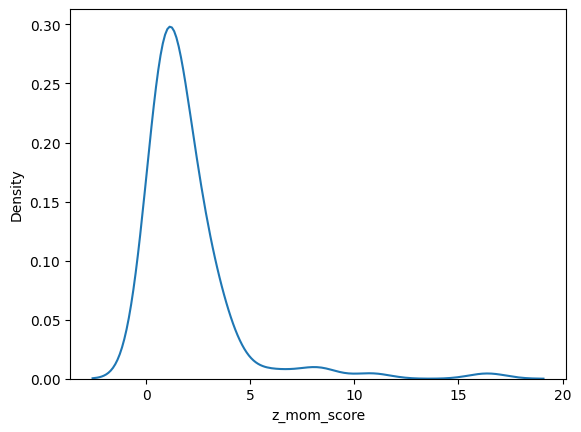

In [182]:
sns.kdeplot(data=z_result, x='z_mom_score')